In [6]:
# Cell 1: Imports & setup
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

# Try to import UMAP
try:
    import umap
    has_umap = True
except ImportError:
    has_umap = False

# Ensure utils/ is on the Python path for imports
project_root = Path.cwd()
sys.path.insert(0, str(project_root))  # Add project root to path

# Import from utils module
from utils.feature_extraction import transform_data
from utils.data_loader_utils import load_data

# Create export directory
export_dir = Path("export")  # Changed to relative path
export_dir.mkdir(exist_ok=True)


ModuleNotFoundError: No module named 'utils'

In [1]:
# Cell 2: Load and transform data
X_data, y_data = load_data()                      # load raw vibration samples & labels


NameError: name 'load_data' is not defined

In [3]:
X, y = transform_data(X_data, y_data, label_type="string", include_metadata=True)  # extract features

Extracting features:   0%|          | 0/1702 [00:00<?, ?it/s]

In [4]:
# don’t do pd.DataFrame(X, …) again; X is already a DataFrame
df = X.copy()
df['status'] = y

# now df.columns will include 'machine' and 'process'
print(df.columns)

df

Index(['axis0_mean_aaa', 'axis0_max_aaa', 'axis0_min_aaa', 'axis0_std_aaa',
       'axis0_kurtosis_aaa', 'axis0_skewness_aaa', 'axis0_entropy_aaa',
       'axis0_mean_aad', 'axis0_max_aad', 'axis0_min_aad',
       ...
       'axis2_mean_ddd', 'axis2_max_ddd', 'axis2_min_ddd', 'axis2_std_ddd',
       'axis2_kurtosis_ddd', 'axis2_skewness_ddd', 'axis2_entropy_ddd',
       'machine', 'process', 'status'],
      dtype='object', length=171)


,axis0_mean_aaa,axis0_max_aaa,axis0_min_aaa,axis0_std_aaa,axis0_kurtosis_aaa,axis0_skewness_aaa,axis0_entropy_aaa,axis0_mean_aad,axis0_max_aad,axis0_min_aad,...,axis2_mean_ddd,axis2_max_ddd,axis2_min_ddd,axis2_std_ddd,axis2_kurtosis_ddd,axis2_skewness_ddd,axis2_entropy_ddd,machine,process,status
0,-10.991404,4541.231502,-4349.812566,1310.989218,3.684345,0.002241,13.161231,0.152372,499.545762,-439.560444,...,-0.223901,662.641629,-926.278896,38.070083,37.578280,-0.909573,14.167624,M01,OP00,0
1,-11.567185,4387.715013,-4330.328997,1311.196879,3.689392,0.000579,13.158127,0.118528,477.866345,-487.383820,...,0.197712,880.045329,-728.211535,37.401571,33.879701,0.624161,14.182913,M01,OP00,0
2,-11.391728,4653.423750,-4785.838722,1311.332192,3.695720,-0.008125,13.168987,-0.017426,505.525783,-619.114509,...,-0.018739,634.223970,-480.199034,36.460751,24.238390,0.080482,14.126589,M01,OP00,0
3,-13.518927,4415.331945,-4402.626471,1316.006555,3.616536,0.007331,13.155008,0.060135,490.759898,-534.575650,...,0.089371,618.587804,-710.922108,37.095871,30.898552,-0.218302,14.104426,M01,OP00,0
4,-14.244809,4391.101813,-4322.837682,1310.944257,3.673275,0.008677,13.176719,0.075658,490.240612,-467.977956,...,0.118642,462.380058,-779.346596,36.324785,26.889594,-0.185641,14.130760,M01,OP00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,32.770570,4333.854335,-4376.570873,981.346096,9.436191,0.005428,10.750572,-1.227136,711.008034,-859.106823,...,-1.106430,634.813784,-682.453427,107.314426,3.029513,0.021949,12.391202,M03,OP13,0
1698,31.914158,4469.658674,-4315.991039,980.478603,9.443749,0.011458,10.724830,1.509277,1035.278252,-676.928198,...,0.502618,671.449107,-763.795250,105.408060,2.513431,0.023117,12.387538,M03,OP13,0
1699,26.897471,4551.681138,-4146.114488,979.123027,9.494843,0.017641,10.658926,0.395453,692.249595,-486.599235,...,0.289976,452.481601,-563.848927,42.888349,17.657391,-0.058146,12.075156,M03,OP13,0
1700,27.195491,4360.633240,-4226.801393,979.287645,9.485268,0.015150,10.658864,0.290150,1626.831600,-1149.578112,...,-0.259574,507.380920,-568.396893,46.871952,21.505350,-0.395340,11.998400,M03,OP13,0


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


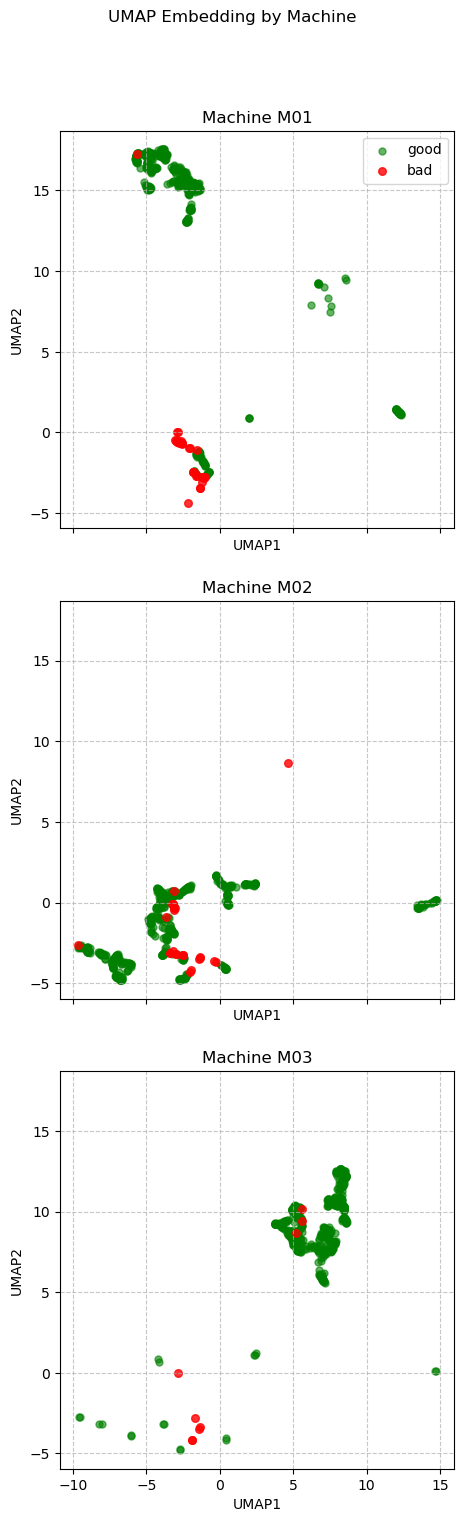

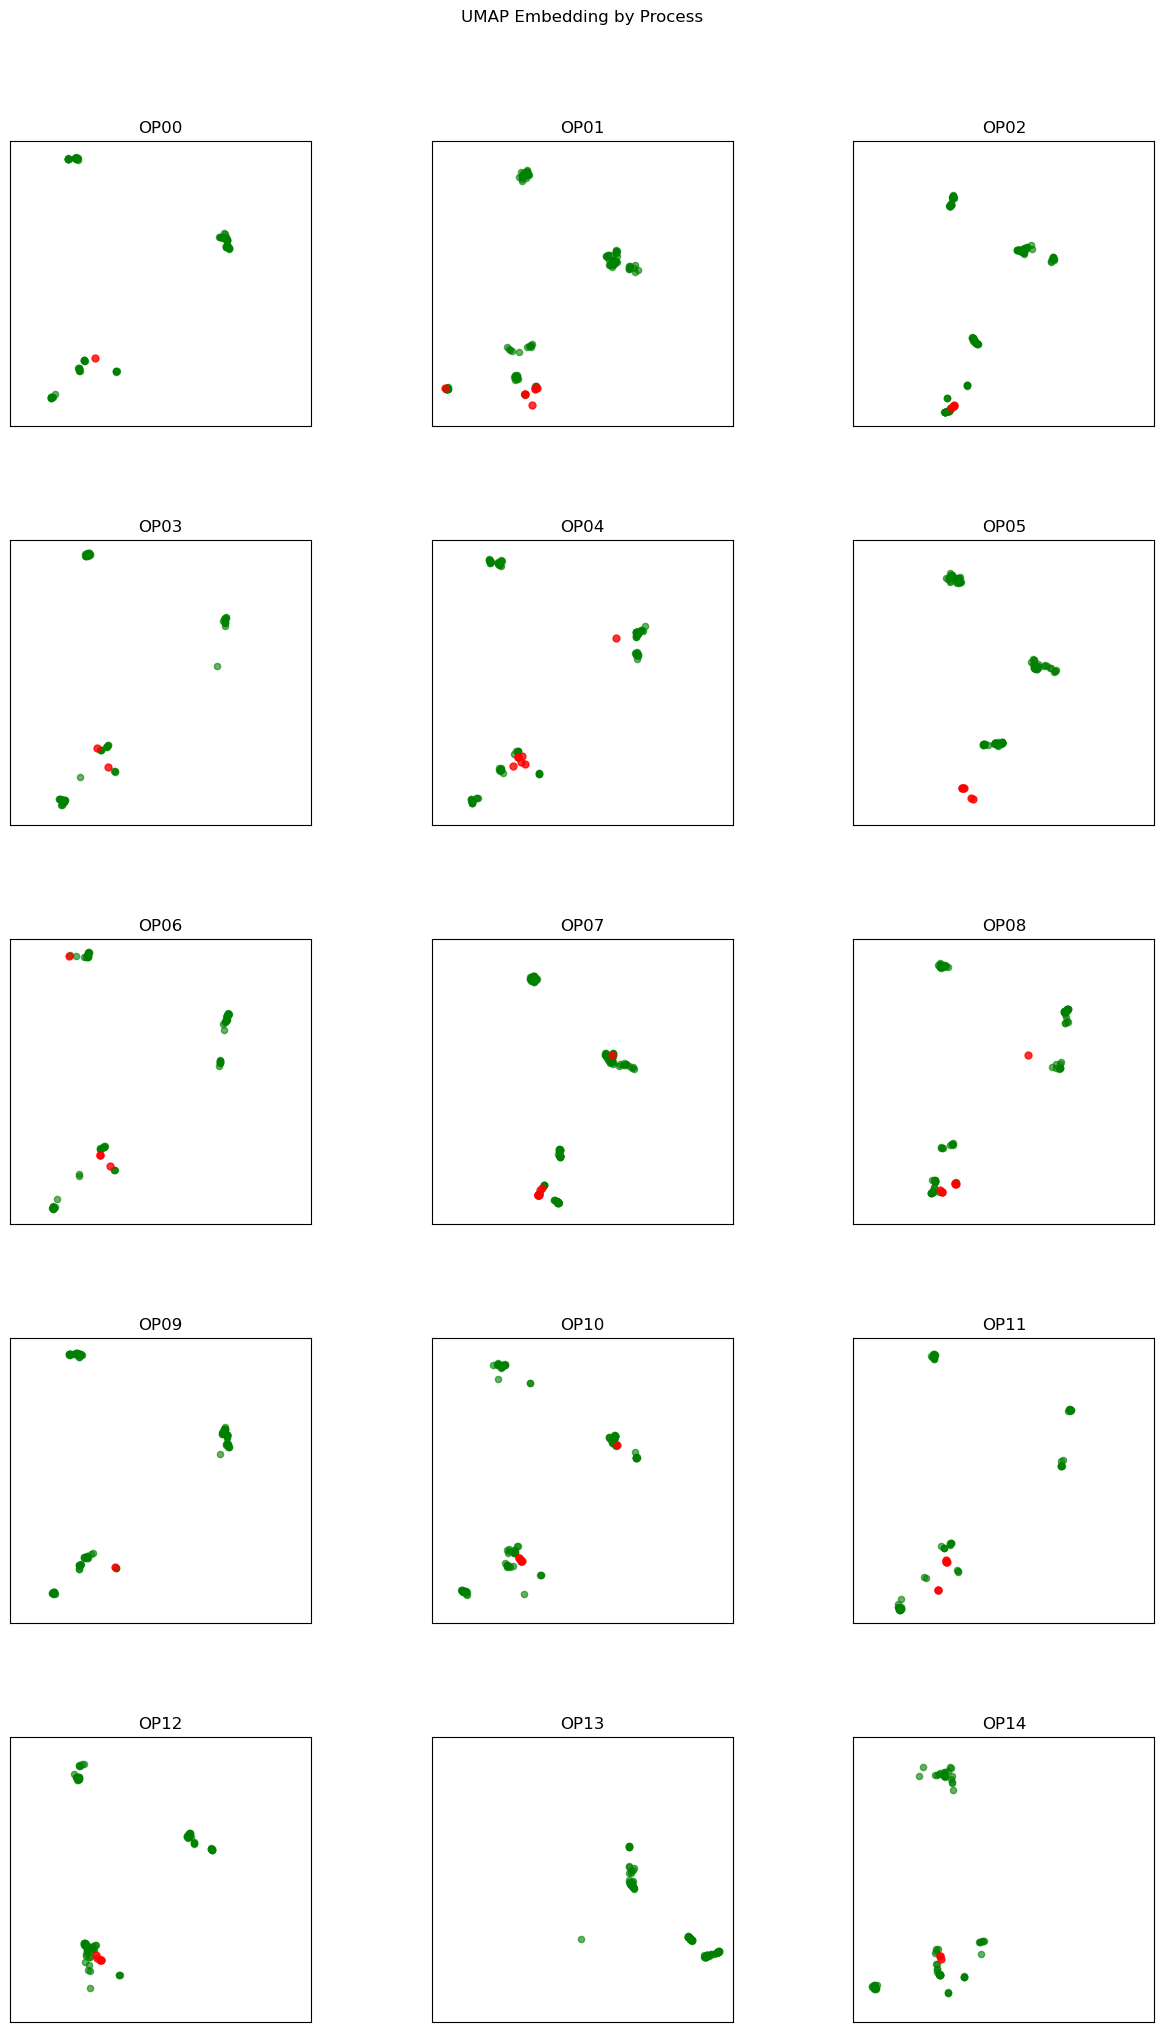

In [6]:
# Cell 8: Combined UMAP plots: one figure per machine, one figure per process
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
# Build df with metadata & status
df_umap = X.copy()
df_umap["status"] = y

# Identify numeric features
meta_cols = ["machine", "process", "status"]
feature_cols = [c for c in df_umap.columns if c not in meta_cols]
X_num = df_umap[feature_cols].values

# Standardize and compute UMAP embedding once
X_scaled = StandardScaler().fit_transform(X_num)
reducer = UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=15,
    min_dist=0.1,
    metric="correlation"
)
emb = reducer.fit_transform(X_scaled)
df_umap["UMAP1"], df_umap["UMAP2"] = emb[:, 0], emb[:, 1]

# 1) One figure with machines stacked vertically (one per machine)
machines = sorted(df_umap["machine"].unique())
fig, axes = plt.subplots(len(machines), 1, figsize=(5, 5 * len(machines)), sharex=True, sharey=True)
for ax, mach in zip(axes, machines):
    sub = df_umap[df_umap["machine"] == mach]
    ax.scatter(sub.loc[sub["status"] == 0, "UMAP1"], sub.loc[sub["status"] == 0, "UMAP2"],
               c="green", alpha=0.6, s=25, label="good")
    ax.scatter(sub.loc[sub["status"] == 1, "UMAP1"], sub.loc[sub["status"] == 1, "UMAP2"],
               c="red", alpha=0.8, s=30, label="bad")
    ax.set_title(f"Machine {mach}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.grid(True, linestyle='--', alpha=0.7)
    if ax is axes[0]:
        ax.legend()
fig.suptitle("UMAP Embedding by Machine", y=1.02)
plt.tight_layout(pad=2.0)  # Increased padding
plt.savefig(export_dir / "umap_by_machine_vertical.png", bbox_inches='tight', pad_inches=0.5)  # Added padding
plt.show()

# 2) One figure with a grid of panels (one per operation), 3 columns
processes = sorted(df_umap["process"].unique())
n_cols = 3
n_rows = (len(processes) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for ax, proc in zip(axes, processes):
    sub = df_umap[df_umap["process"] == proc]
    ax.scatter(sub.loc[sub["status"] == 0, "UMAP1"], sub.loc[sub["status"] == 0, "UMAP2"],
               c="green", alpha=0.6, s=20)
    ax.scatter(sub.loc[sub["status"] == 1, "UMAP1"], sub.loc[sub["status"] == 1, "UMAP2"],
               c="red", alpha=0.8, s=25)
    ax.set_title(proc)
    ax.grid(True, linestyle='--', alpha=0.7)  # Added grid lines
    ax.set_xticks([]); ax.set_yticks([])

# Hide unused subplots
for ax in axes[len(processes):]:
    ax.set_visible(False)

fig.suptitle("UMAP Embedding by Process", y=1.02)
plt.tight_layout(pad=2.0)  # Increased padding
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Increased spacing between subplots
plt.savefig(export_dir / "umap_by_process.png", bbox_inches='tight', pad_inches=0.5)  # Added padding
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



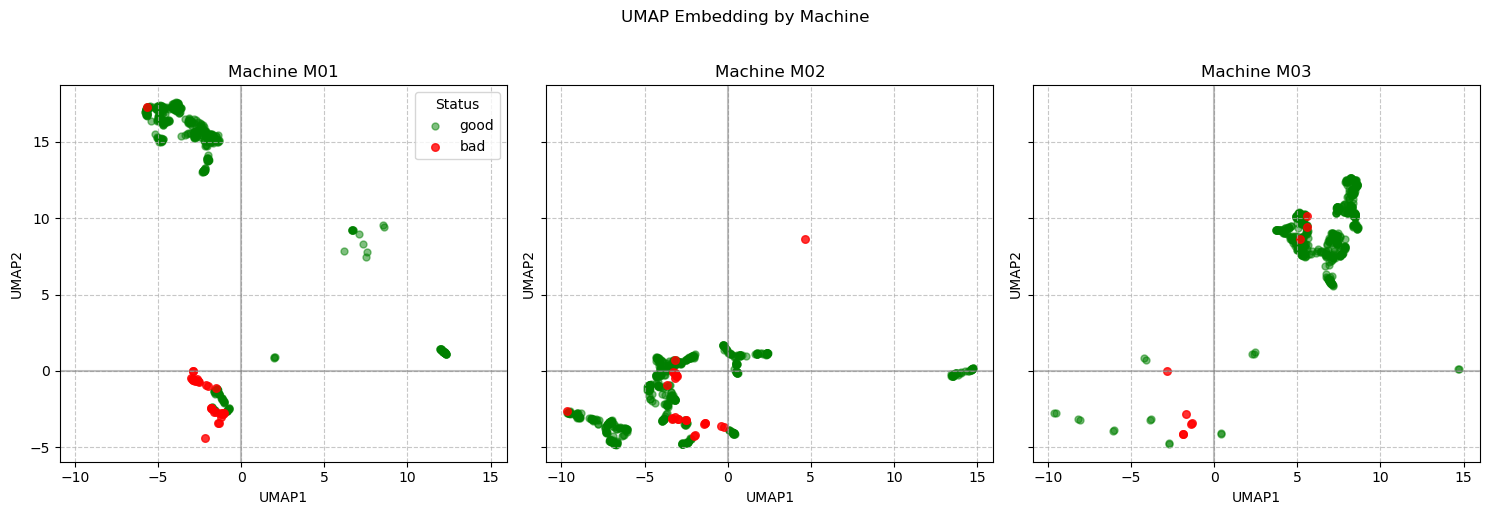

In [28]:
# UMAP Visualization: Machine-specific plot
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Build df with metadata & status
df_umap = X.copy()
df_umap["status"] = y

# Identify numeric features
meta_cols = ["machine", "process", "status"]
feature_cols = [c for c in df_umap.columns if c not in meta_cols]
X_num = df_umap[feature_cols].values

# Standardize and compute UMAP embedding once
X_scaled = StandardScaler().fit_transform(X_num)
reducer = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="correlation",
    random_state=42  # Set a fixed random state for reproducibility
)
emb = reducer.fit_transform(X_scaled)
df_umap["UMAP1"], df_umap["UMAP2"] = emb[:, 0], emb[:, 1]

# One figure with machines side by side (one per machine)
machines = sorted(df_umap["machine"].unique())
fig, axes = plt.subplots(1, len(machines), figsize=(15, 5), sharex=True, sharey=True)
for ax, mach in zip(axes, machines):
    sub = df_umap[df_umap["machine"] == mach]
    ax.scatter(
        sub.loc[sub["status"] == 0, "UMAP1"],
        sub.loc[sub["status"] == 0, "UMAP2"],
        c="green", alpha=0.5, s=25, label="good"
    )
    ax.scatter(
        sub.loc[sub["status"] == 1, "UMAP1"],
        sub.loc[sub["status"] == 1, "UMAP2"],
        c="red", alpha=0.8, s=30, label="bad"
    )
    
    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal and vertical lines at origin
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
    
    ax.set_title(f"Machine {mach}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    if ax is axes[0]:
        ax.legend(title="Status")
fig.suptitle("UMAP Embedding by Machine", y=1.02)
plt.tight_layout()
plt.savefig(export_dir / "umap_by_machine_horizontal.png", bbox_inches='tight', pad_inches=0.5)
plt.show()

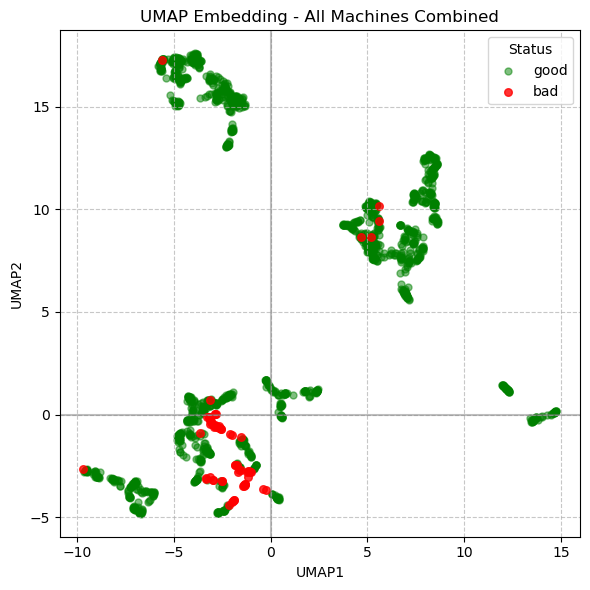

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    df_umap.loc[df_umap["status"] == 0, "UMAP1"],
    df_umap.loc[df_umap["status"] == 0, "UMAP2"],
    c="green", alpha=0.5, s=25, label="good"
)
ax.scatter(
    df_umap.loc[df_umap["status"] == 1, "UMAP1"],
    df_umap.loc[df_umap["status"] == 1, "UMAP2"],
    c="red", alpha=0.8, s=30, label="bad"
)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Add horizontal and vertical lines at origin
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='-', alpha=0.5)

ax.set_title("UMAP Embedding - All Machines Combined")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.legend(title="Status")
plt.tight_layout()
plt.savefig(export_dir / "umap_all_machines.png")
plt.show()

In [8]:
# Install necessary packages if not already installed
try:
    import plotly.express as px
except ImportError:
    !pip install plotly
    import plotly.express as px

from umap.umap_ import UMAP
    
# Select features for UMAP (excluding metadata columns)
feature_cols = [col for col in X.columns if col not in ['machine', 'process']]
X_features = X[feature_cols]

# Create 3D UMAP embedding
reducer_3d = UMAP(n_components=3, 
                  n_neighbors=15, 
                  min_dist=0.1, 
                  metric='euclidean',
                  random_state=42)
embedding_3d = reducer_3d.fit_transform(X_features)

# Create a DataFrame for visualization
df_umap_3d = pd.DataFrame({
    'UMAP1': embedding_3d[:, 0],
    'UMAP2': embedding_3d[:, 1],
    'UMAP3': embedding_3d[:, 2],
    'status': y,
    'machine': X['machine'],
    'process': X['process']  # Added process/operation
})

# Convert status to string for better visualization
df_umap_3d['status'] = df_umap_3d['status'].map({0: 'good', 1: 'bad'})

# Create an interactive 3D plot with Plotly
fig = px.scatter_3d(
    df_umap_3d, 
    x='UMAP1', 
    y='UMAP2', 
    z='UMAP3',
    color='status',
    symbol='machine',
    hover_data=['process'],  # Include process in hover information
    opacity=0.7,
    title='3D UMAP Visualization of Vibration Data',
    labels={'status': 'Status', 'machine': 'Machine', 'process': 'Operation'},
    color_discrete_map={'good': 'blue', 'bad': 'red'}
)

# Improve layout
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()

# Save the figure to the export directory
fig.write_html(export_dir / "umap_3d_visualization.html")
print(f"3D UMAP visualization saved to {export_dir / 'umap_3d_visualization.html'}")


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


3D UMAP visualization saved to ../export/umap_3d_visualization.html
